# Apply Pre-Trained Model

This notebook shows you how you can apply a pre-trained model provided in this repository to some household data. Note that when applying the models to your own data, it should follow the structure provided in the CSV files under the folder ```data/customer_data/```. This means that a dataframe is expected to cover one household and to include the total energy consumption including the heat pump, alongside the weather data (daily average temperature, hourly average temperature, daily maximum temperature, daily minimum temperature). The order of the the weather data also needs to be preserved as the models provided here have been trained with the features representing this order. Further note that all models where trained with energy data in 15 minute resolution. If your data has a different resolution, you will get corrupted results and instead you should train your own models, following the instructions provided in ```notebooks/01_train_nn.ipynb```.

### Imports

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# import the code from this repository provided in the src folder
sys.path.append(os.path.dirname(os.getcwd())+'/src') 
from utils import *
from model import * 

### Choose Model Provided in Repository

The file ```/models/model_mapping.csv``` is an overview of the different types of models evaluated in the paper and provided in this repo. The models mainly differ in the number of nodes per layer used, the sliding window configurations and whether a feature was used that indicated for each household if the heat pump is also responsible for domestic hot water production (see paper for more details). Since a 5-fold cross validation was used for evaluation, each type of model was trained 5 times on different folds, meaning that different combinations of households were used for training (80%) and testing (20%). Consequently the ```/models/```-folder provides five versions of each model type with subfolders named by the corresponding fold (e.g., ```/models/Model1/Fold3/```). When applying a model to your own data, you are free to choose any fold from 0 to 4, as the results should not differ substantially. However, you are also free to test in a trial and error manner which model performs best in your case. Within the folder related to each model and fold, you will find a subfolder which stores the ```keras```-related object fields (e.g., ```/models/Model1/Fold3/model/```) and a subfolder for the ```sklearn``` scaler object used for normalization (e.g., ```/models/Model1/Fold3/scaler/```). 

The code below shows you how to choose a model from the overview and how to extract the relevant information that is needed to restore the model afterwards.

In [2]:
# ------------------------------------------
# LOAD MODEL INFORMATION FROM OVERVIEW CSV 
# ------------------------------------------

# load overview of the models available 
df_models = pd.read_csv(os.path.dirname(os.getcwd()) + '/models/model_mapping.csv', sep=';')
display(df_models)

# ------------------------------------------
# CHOOSE A MODEL AND FOLD 
# ------------------------------------------

modelnr = 4
fold = 0
print('Selected model {} and fold {}.'.format(modelnr, fold))

# ------------------------------------------
# EXTRACT RELEVANT INFORMATION FROM OVERVIEW
# ------------------------------------------

# select the corresponding row in the overview data frame 
row = df_models[df_models['ModelNumber'] == modelnr].iloc[0]

# reconstruct the list of integers that define the number of layers and number of nodes per layer
layer_shapes = row['LayerShapes'].replace('[', ',').replace(']', ',') 
layer_shapes = [int(e) for e in layer_shapes[1:-1].split(',')]

# extract the width and overlap of sliding windows 
window_length = row['WindowSize'] 
window_overlap = row['WindowOverlap']

# select whether the feature was used describing DHW production of the heat pump
feat_dhw = row['MetaFeature']

# -----------------------------------------------------------------------------
# CONFIGURE SOME PARAMETERS THAT WERE IDENTICAL ACROSS ALL MODELS PROVIDED HERE
# -----------------------------------------------------------------------------

# all models used features to encode the time as cyclic features
feat_time = True 

# all models used the mean of the energy consumption in a sliding window as features next to the energy sequence
feat_energymean = True 

# all models used weather related features 
feat_weather = True

# the weather related features were the ones below - NOTE: order matters (the names refer to the columns of the data frames in /data/customer_data/<customer_id>.csv)
weather_columns = ['daily_avgtemp', 'hourly_avgtemp', 'daily_maxtemp', 'daily_mintemp']

,ModelNumber,LayerShapes,WindowSize,WindowOverlap,MetaFeature
0,1,"[50,100,200,100,50]",8,2,False
1,2,"[50,100,200,100,50]",8,2,True
2,3,"[50,100,200,100,50]",8,4,False
3,4,"[50,100,200,100,50]",8,4,True
4,5,"[50,100,200,100,50]",8,6,False
5,6,"[50,100,200,100,50]",8,6,True
6,7,"[50,100,200,100,50]",8,7,False
7,8,"[50,100,200,100,50]",8,7,True
8,9,"[200,400,800,400,200]",96,24,False
9,10,"[200,400,800,400,200]",96,24,True


Selected model 4 and fold 0.


### Reconstruct Pre-Trained Model

The code below shows you how you can reconstruct the model based on the information from the previous cell. Basically, it boils down to the following steps: 
1. Create an instance of class ```Model()```
2. Restore the keras model object.
3. Restore the scaler object used for normalization (if any scaling was used).

Note that during model initialization (i.e., step 1), we do not provide any relevant training arguments other than the layer shapes. This is because all models were trained with the standard configurations. However, if you want to restore your own saved models, you need to make sure to save your configurations in addition to the models and scalers (e.g., in a dictionary via ```pickle```) and recall them here, respectively.

In [3]:
# navigate to where the chosen model is stored
folder = os.path.dirname(os.getcwd()) + '/models/Model{}/Fold{}/'.format(modelnr, fold)

# create a new model instance 
model = Model('restored_model', layer_shapes=layer_shapes, apple_silicon=True)

# load keras model object
model.load_keras_model(folder+'model/')

# load sklearn scaler object
model.load_X_scaler(folder+'scaler/Xscaler.sav', overwrite_scaler_configuration=True)

[24/02/19 17:06:24 restored_model] [DEBUG] Handler: Intialization successful. Name: restored_model
[24/02/19 17:06:24 restored_model] [DEBUG] Model.set_epochs(): Number of epochs set to 200.
[24/02/19 17:06:24 restored_model] [DEBUG] Model.set_batch_size(): Batch size set to 2048.
[24/02/19 17:06:24 restored_model] [DEBUG] Model.__init__(): Object creation successful.


### Apply Restored Model to Test Household

The following code shows you how to apply the restored model to data provided in ```data/customer_data/<customer_id>.csv```. Again the following steps are performed: 

1. Load the data. 
2. Calculate the features in sliding windows. 
3. Use the model to get a prediction of the heat pump related energy sequence per sliding window. 
4. Reconstruct an original time series by averaging predictions that refer to the same timestamp across the different windows. 

In [13]:
# load overview of systems with available data 
df_systems = pd.read_csv(os.path.dirname(os.getcwd()) + '/data/meta_data.csv')

# select a row corresponding to a household of interest 
row_idx = 2
row = df_systems.iloc[row_idx]

# get customer id and information whether HP is responsible for DHW production
customer_id = row['customer_id']
dhw_value = bool(row['dhw_production'])

# load original smart meter and weather data frame 
df = pd.read_csv('{}/data/customer_data/{}.csv'.format(os.path.dirname(os.getcwd()), customer_id))
df['timestamp'] = pd.to_datetime(df['timestamp'])

# create the sliding windows and features, serving as input to the network
np_features = create_features_array_from_original_data_frame(df, window_length, window_overlap, 'kWh_aggregated', dhw_value=dhw_value, key_timestamp='timestamp', feat_energymean=feat_energymean, feat_time=feat_time, feat_weather=feat_weather, feat_dhw=feat_dhw, weather_columns=weather_columns, remove_last_window=False)

# use the restored model to predict the energy sequences per sliding window
np_predictions = model.predict(np_features)

# transform the sliding window predictions back into time series and add as new column to original data frame
df_predicted = create_data_series_from_sliding_windows(np_predictions, window_overlap, df_original=df, new_column_name='kWh_heat_pump_predicted')

# move column more to the front and round values 
df_predicted.insert(3, 'kWh_heat_pump_predicted', df_predicted.pop('kWh_heat_pump_predicted'))
df_predicted['kWh_heat_pump_predicted'] = df_predicted['kWh_heat_pump_predicted'].round(3)

# drop potential NaN values (can occur at the end of the time series)
df_predicted.dropna(subset=['kWh_heat_pump', 'kWh_heat_pump_predicted'], inplace=True)

# show data frame 
display(df_predicted)


,timestamp,kWh_aggregated,kWh_heat_pump,kWh_heat_pump_predicted,kWh_other_appliances,hourly_avgtemp,daily_avgtemp,daily_maxtemp,daily_mintemp
0,2017-09-04 00:15:00+00:00,0.00,0.00,0.000,0.00,7,16,19,7
1,2017-09-04 00:30:00+00:00,0.00,0.00,0.000,0.00,7,16,19,7
2,2017-09-04 00:45:00+00:00,0.00,0.00,0.000,0.00,7,16,19,7
3,2017-09-04 01:00:00+00:00,0.00,0.00,0.000,0.00,8,16,19,7
4,2017-09-04 01:15:00+00:00,0.00,0.00,0.000,0.00,8,16,19,7
...,...,...,...,...,...,...,...,...,...
89363,2020-03-22 23:00:00+00:00,0.20,0.02,0.015,0.18,-1,3,5,0
89364,2020-03-22 23:15:00+00:00,0.54,0.49,0.334,0.05,-1,3,5,0
89365,2020-03-22 23:30:00+00:00,0.87,0.81,0.607,0.06,-1,3,5,0
89366,2020-03-22 23:45:00+00:00,0.85,0.81,0.656,0.04,-1,3,5,0


### Evaluate Performance

Below you find an example of how you can evaluate the performance of a prediction for a specific household, when the original sequence of the heat pump's energy consumption is known. In practice, you would most likely calculate the scores per household, concatenate all data frames and then calculate the average and standard deviation of each score. 

In [14]:
# create an instance of the result reporter, which calculates the scores - NOTE: you need to create one instance per household! 
reporter = ResultReporter('regression', groundtruth=df_predicted['kWh_heat_pump'].values, predictions=df_predicted['kWh_heat_pump_predicted'].values)
df_scores = reporter.getResultDataFrame(only_relevant_metrics=True, parameter_evaluated='customer_id:{}'.format(customer_id))
display(df_scores)

,task_type,parameter_evaluated,meanAbsoluteError,meanSquaredError,rootMeanSquaredError,rootMeanSquaredLogError,R2Score,maxResidualError,medianAbsoluteError
0,regression,customer_id:1077878,0.042522,0.007552,0.086901,-2.44298,0.966105,1.22,0.014


### Visualize Results

The following cell shows exemplary heat maps andx lineplots of the original energy consumption (total and heat pump) and disaggregated heat pump energy consumption.

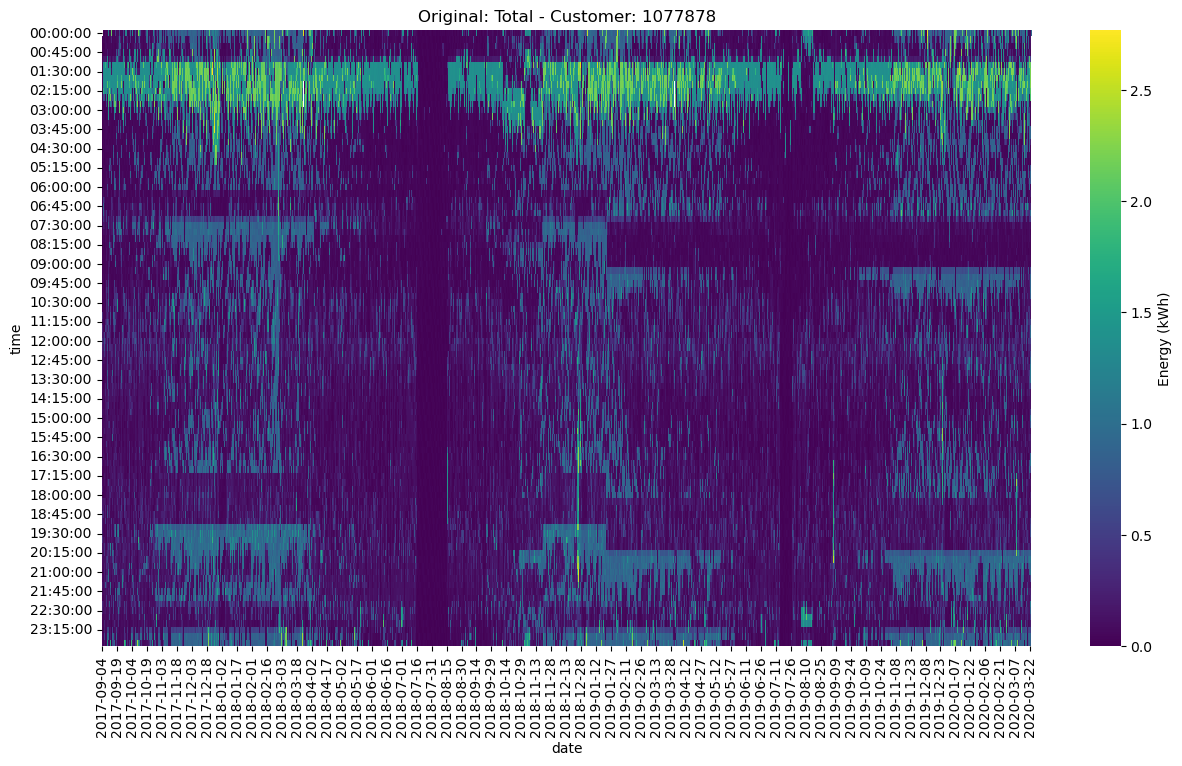

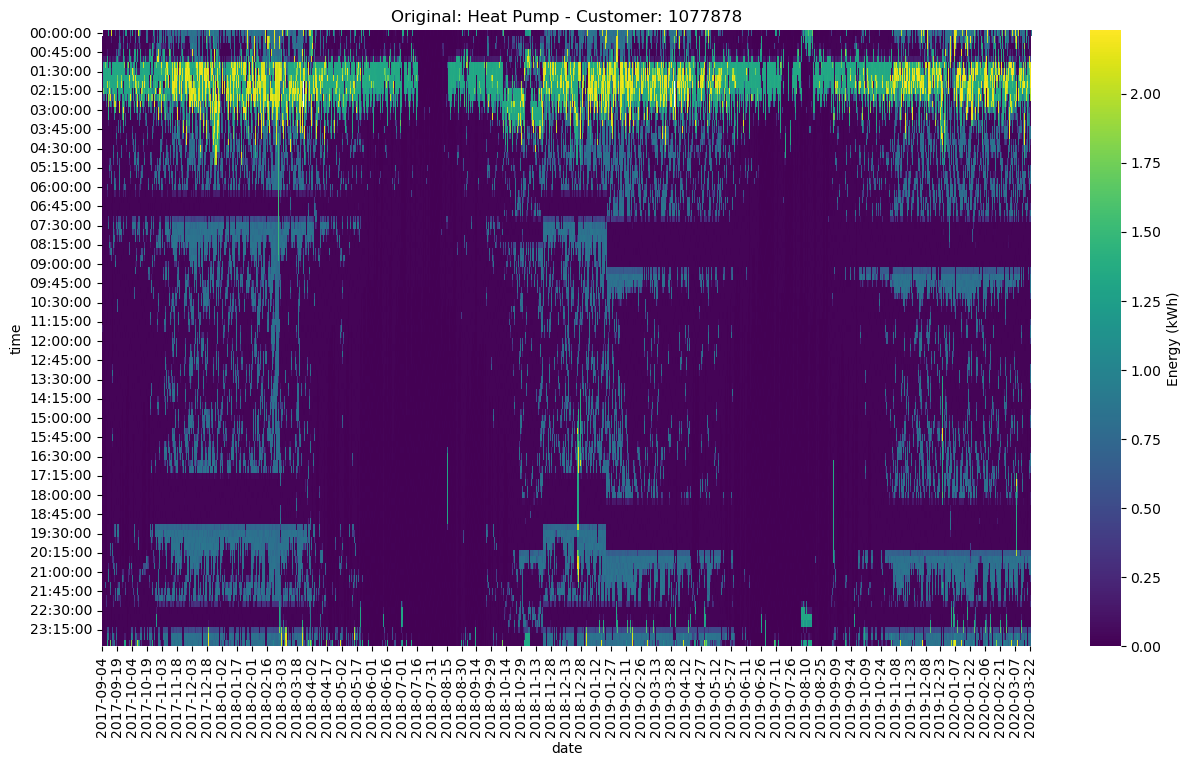

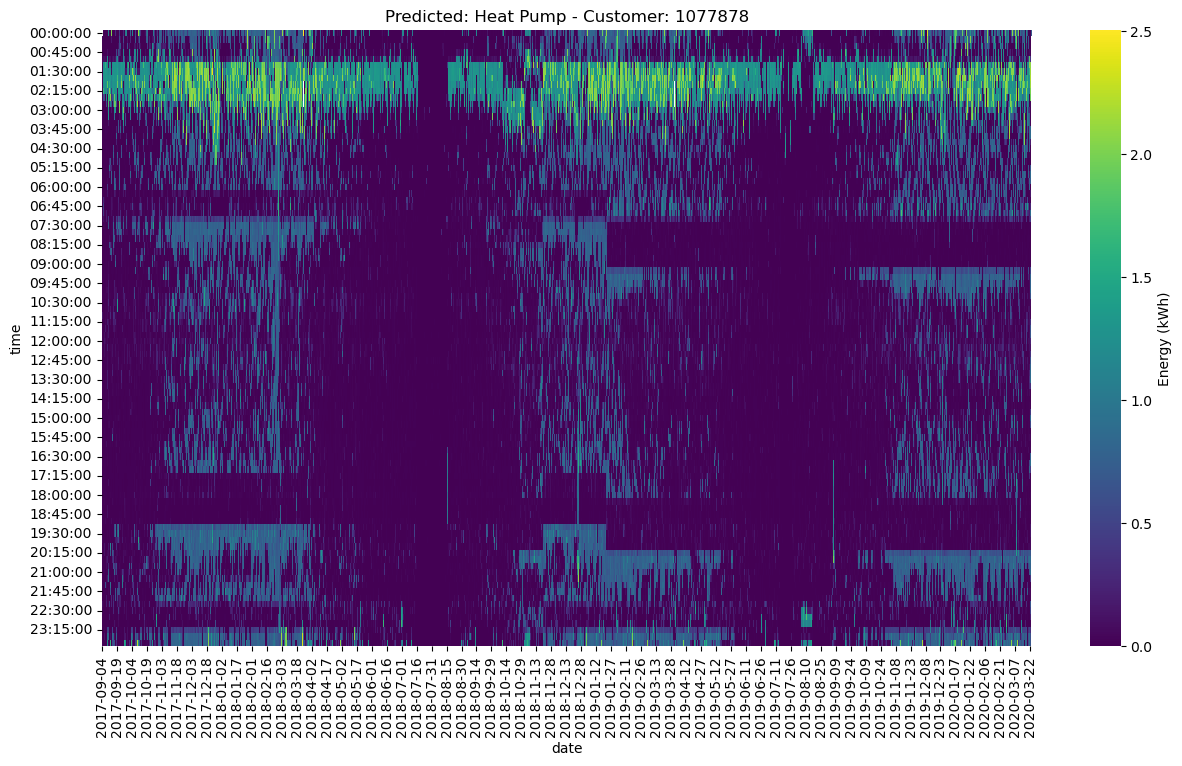

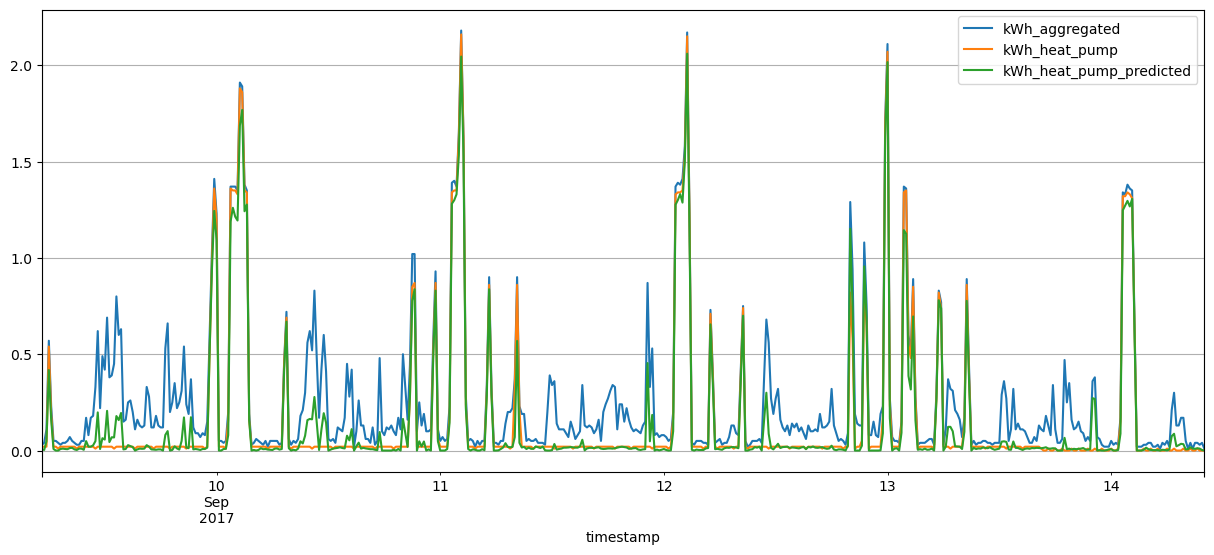

In [15]:
# dictionary for titles 
titles = {'kWh_aggregated': 'Original: Total', 'kWh_heat_pump': 'Original: Heat Pump', 'kWh_heat_pump_predicted': 'Predicted: Heat Pump'}

# visualize energy data as heat map
for col in titles.keys():
    
    hm = create_heatmap_data(df_predicted.set_index('timestamp'), column=col)
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.heatmap(hm, ax=ax, cbar_kws={'label': 'Energy (kWh)'}, cmap='viridis')
    ax.set_title('{} - Customer: {}'.format(titles[col], customer_id))
    plt.show()

df_predicted.copy().set_index('timestamp')[titles.keys()].iloc[500:1000].plot(figsize=(15, 6), grid=True)
plt.show()